In [2]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from river.decomposition import OnlineDMD
from river.preprocessing import Hankelizer
from tqdm import tqdm

sys.path.append("../")
from functions.chdsubid import SubIDChangeDetector
from functions.plot import plot_chd, set_size
from functions.rolling import Rolling

In [3]:
%load_ext autoreload
%autoreload 2

Text(0.5, 0, 'Time')

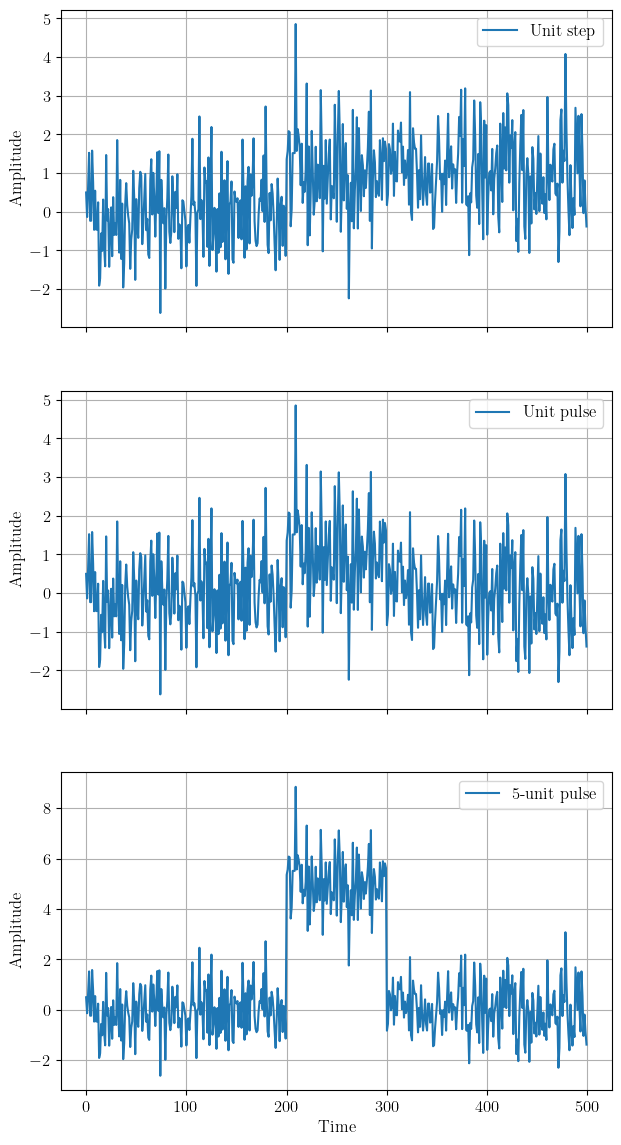

In [4]:
np.random.seed(42)

# Generate time vector
t = np.arange(0, 500)

# Generate unit pulse signal
X = np.random.normal(0, 1, size=len(t))
X_unit_step = X.copy()
X_unit_step[200:] += 1.0
# X_step = X.copy()
# X_step[200:] += 5.0
X_unit_pulse = X.copy()
X_unit_pulse[200:300] += 1.0
X_pulse = X.copy()
X_pulse[200:300] += 5.0
# X_noise = X.copy()

Xs = {
    "Unit step": X_unit_step,
    # "5 unit step": X_step,
    "Unit pulse": X_unit_pulse,
    "5-unit pulse": X_pulse,
    # "Noise": X_noise,
}

# Plot the signals
fig, axs = plt.subplots(
    len(Xs), 1, figsize=set_size(width="article", subplots=(3, 1)), sharex=True
)
for ax, (name, X) in zip(axs, Xs.items()):
    ax.plot(t, X, label=name)
    ax.set_ylabel("Amplitude")
    ax.legend()
axs[-1].set_xlabel("Time")

In [5]:
from river.compose import Pipeline


def progressive_val_predict(dataset, model, compute_alt_scores=False):
    # CREATE REFERENCE TO LAST STEP OF PIPELINE (TRACK STATE OF MODEL)
    if isinstance(model, Pipeline):
        model_ = model._last_step
    else:
        model_ = model

    y_pred = np.zeros(X.shape[0], dtype=float)
    meta: dict[str, np.ndarray] = {}
    if compute_alt_scores:
        meta["scores_dmd_diff"] = np.zeros(X.shape[0], dtype=float)

    # Run pipeline
    for i, (x) in tqdm(
        enumerate(dataset),
        total=len(dataset),
        mininterval=1.0,
        desc="Snapshots processed",
    ):
        y_pred[i] = model.score_one({"x": x})
        if compute_alt_scores:
            meta["scores_dmd_diff"][i] = (
                model_.distances[1] - model_.distances[0]
            ).real

        model.learn_one({"x": x})
    return y_pred, meta

Snapshots processed: 100%|██████████| 500/500 [00:03<00:00, 137.97it/s]


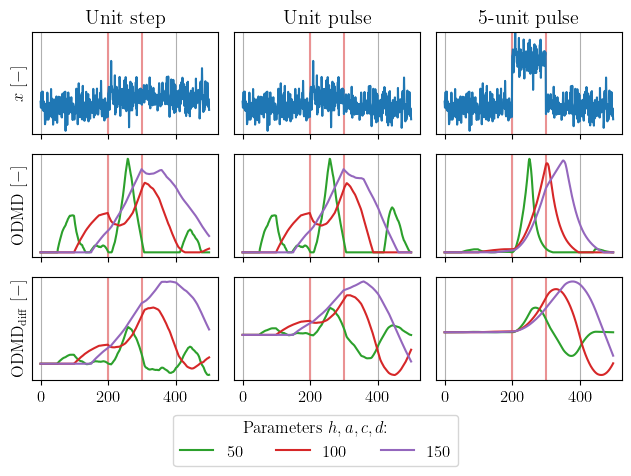

In [54]:
# [donotremove]
range_vals = [50, 100, 150]
ranges_params = {
    "hn": range_vals,
    "window_size": range_vals,
    "ref_size": range_vals,
    "test_size": range_vals,
}

# [donotremove]
fig, axs = plt.subplots(
    3,
    len(Xs),
    sharex=True,
    figsize=set_size(width="article", subplots=(3, len(Xs))),
)

axs = axs.T

for idx_exp, (axs_, (x_name, X)) in enumerate(zip(axs, Xs.items())):
    axs_[0].set_title(x_name)
    # Skip the first color in the color cycle
    # Plot an invisible line to advance the color cycle
    for ax in axs_[1:]:
        ax.plot([], [])
        ax.plot([], [])

    for idx_val, values in enumerate(zip(*ranges_params.values())):
        params = dict(zip(ranges_params.keys(), values))
        hn = params["hn"]
        r = 1
        window_size = params["window_size"]
        ref_size = params["ref_size"]
        test_size = params["test_size"]

        hankelizer = Hankelizer(hn)

        # Initialize Transformer
        # Using Rolling requires scaler to be added
        odmd = Rolling(
            OnlineDMD(
                r=r,
                initialize=window_size - 1,
                w=1.0,
                exponential_weighting=False,
                seed=42,
            ),
            window_size=window_size,
        )
        # Initialize Change-Point Detector
        subid_dmd = SubIDChangeDetector(
            odmd,
            ref_size=ref_size,
            test_size=test_size,
            grace_period=window_size + r,
            start_soon=True,
        )

        # Build pipeline
        pipeline_dmd = hankelizer | subid_dmd

        scores_dmd, meta_dmd = progressive_val_predict(
            X, pipeline_dmd, compute_alt_scores=True
        )
        scores_dmd_diff = meta_dmd["scores_dmd_diff"]
        fig, axs_ = plot_chd(
            [
                X if idx_val == 0 else None,
                scores_dmd.real,
                scores_dmd_diff.real,
            ],
            [200, 300] if idx_val == 0 else None,
            [
                "X",
                f"${values[0]}$",
                f"${values[0]}$",
            ],
            axs=axs_,
        )
        axs_[0].set_ylim(-3, 8)
        handles, labels = axs_[-1].get_legend_handles_labels()
        for ax in axs_:
            ax.set_yticks([])
            # ax.tick_params(axis="y", rotation=90)
            ax.legend().remove()  # Remove individual legends

for ax, ylabel in zip(
    axs[0], ["$x~[-]$", "ODMD [$-$]", "ODMD$_\\mathrm{diff}$ [$-$]"]
):
    ax.set_ylabel(ylabel)
w, h = fig.get_size_inches()
fig.set_size_inches(w, 3 * w / h)
fig.legend(
    handles,
    labels,
    loc="center",
    ncol=len(ranges_params),
    bbox_to_anchor=(0.5, 0.075),
    title="Parameters $h,a,c,d$:",
)
fig.tight_layout(w_pad=1.0)
fig.subplots_adjust(bottom=0.2)
fig_name = "results/.synthetic-steps/parameters-influence-allatonce.pdf"
os.makedirs(os.path.dirname(fig_name), exist_ok=True)
fig.savefig(fig_name)

Snapshots processed: 100%|██████████| 500/500 [00:02<00:00, 189.85it/s]


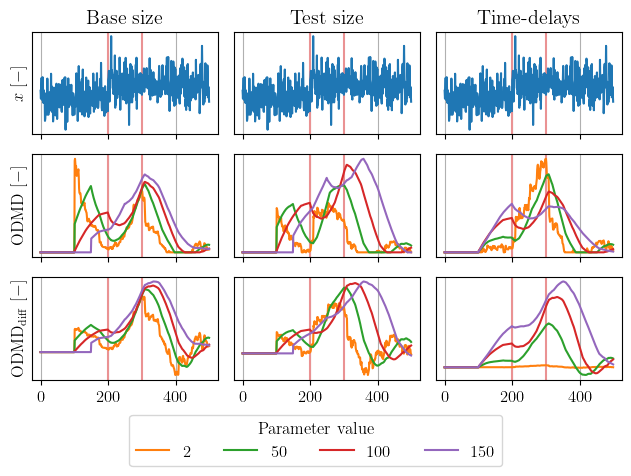

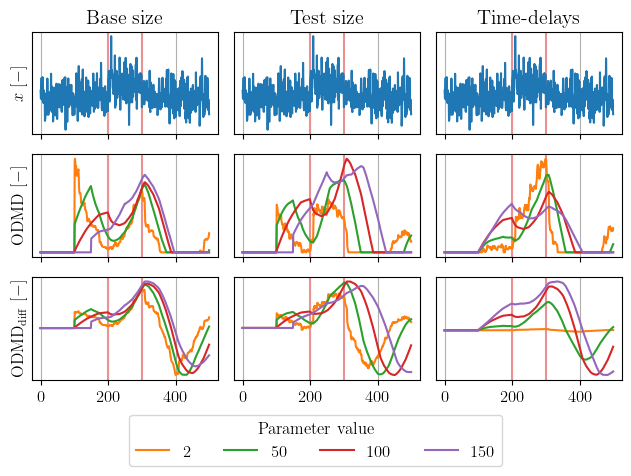

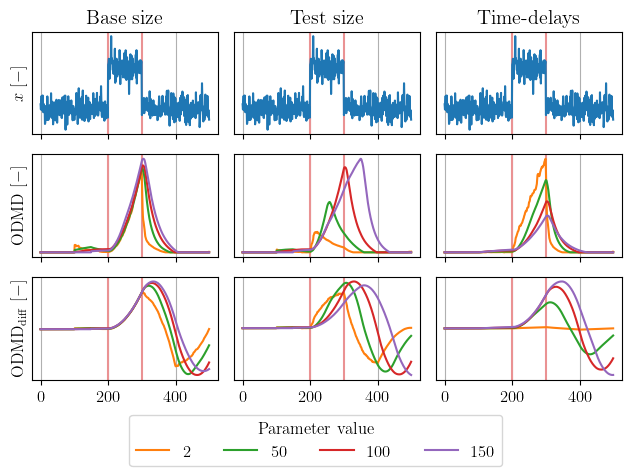

In [56]:
# [donotremove]
opt_params = {
    "window_size": 100,
    "ref_size": 100,
    "test_size": 100,
    "hn": 100,
    "r": 1,
}

range_vals = [2, 50, 100, 150]
ranges_params = {
    # "window_size": range_vals,
    "ref_size": range_vals,
    "test_size": range_vals,
    "hn": range_vals,
}

param_names = {
    # "r": "SVD Rank",
    # "window_size": "Learning size",
    "ref_size": "Base size",
    "test_size": "Test size",
    "hn": "Time-delays",
}

for x_name, X in Xs.items():
    fig, axs = plt.subplots(
        3,
        len(ranges_params),
        sharex=True,
        figsize=set_size(width="article", subplots=(3, len(ranges_params))),
    )

    axs = axs.T

    for idx_exp, (axs_, (param, values)) in enumerate(
        zip(axs, ranges_params.items())
    ):
        axs_[0].set_title(param_names[param])
        for ax in axs_[1:]:
            ax.plot([], [])
        params = opt_params.copy()
        for idx_val, value in enumerate(values):
            params[param] = value
            hn = params["hn"]
            r = params["r"]
            window_size = params["window_size"]
            ref_size = params["ref_size"]
            test_size = params["test_size"]

            hankelizer = Hankelizer(hn)

            # Initialize Transformer
            # Using Rolling requires scaler to be added
            odmd = Rolling(
                OnlineDMD(
                    r=r,
                    initialize=window_size - 1,
                    w=1.0,
                    exponential_weighting=False,
                    seed=42,
                ),
                window_size=window_size,
            )
            # Initialize Change-Point Detector
            subid_dmd = SubIDChangeDetector(
                odmd,
                ref_size=ref_size,
                test_size=test_size,
                grace_period=window_size + r,
                start_soon=True,
            )

            # Build pipeline
            pipeline_dmd = hankelizer | subid_dmd

            scores_dmd, meta_dmd = progressive_val_predict(
                X, pipeline_dmd, compute_alt_scores=True
            )
            scores_dmd_diff = meta_dmd["scores_dmd_diff"]
            fig, axs_ = plot_chd(
                [
                    X if idx_val == 0 else None,
                    scores_dmd.real,
                    scores_dmd_diff.real,
                ],
                [200, 300] if idx_val == 0 else None,
                [
                    "X",
                    f"${value}$",
                    f"${value}$",
                ],
                # grace_period=test_size,
                axs=axs_,
            )

            handles, labels = axs_[-1].get_legend_handles_labels()
            for ax in axs_:
                ax.set_yticks([])
                # ax.tick_params(axis="y", rotation=90)
                ax.legend().remove()  # Remove individual legends

    for ax, ylabel in zip(
        axs[0], ["$x~[-]$", "ODMD [$-$]", "ODMD$_\\mathrm{diff}$ [$-$]"]
    ):
        ax.set_ylabel(ylabel)
    w, h = fig.get_size_inches()
    fig.set_size_inches(w, 3 * w / h)
    fig.legend(
        handles,
        labels,
        loc="center",
        ncol=len(range_vals),
        bbox_to_anchor=(0.5, 0.075),
        title="Parameter value",
    )
    fig.tight_layout(w_pad=1.0)
    fig.subplots_adjust(bottom=0.2)
    fig_name = (
        f"results/.synthetic-steps/{x_name}-parameters-influence-"
        f"{"_".join(str(x) for x in ranges_params.keys())}.pdf"
    )
    os.makedirs(os.path.dirname(fig_name), exist_ok=True)
    fig.savefig(fig_name)

Snapshots processed: 100%|██████████| 500/500 [00:02<00:00, 234.24it/s]


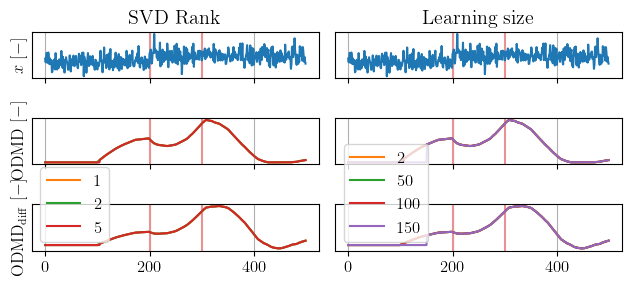

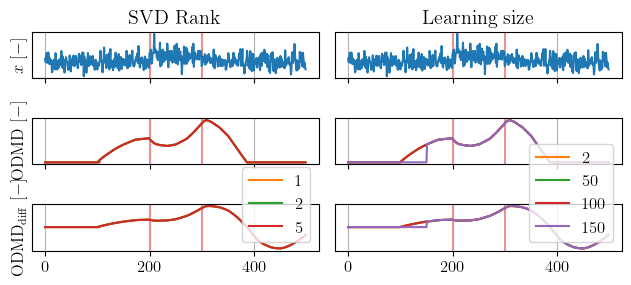

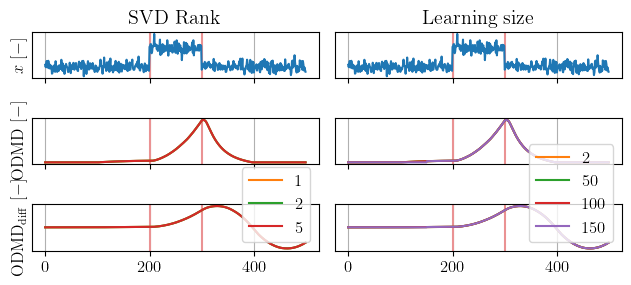

In [6]:
# [donotremove]
opt_params = {
    "window_size": 100,
    "ref_size": 100,
    "test_size": 100,
    "hn": 100,
    "r": 1,
}

ranges_params = {
    "r": [1, 2, 5],
    "window_size": [2, 50, 100, 150],
}

param_names = {
    "r": "SVD Rank",
    "window_size": "Learning size",
    "ref_size": "Base size",
    "test_size": "Test size",
    "hn": "Time-Delays",
}

for x_name, X in Xs.items():
    fig, axs = plt.subplots(
        3,
        len(ranges_params),
        sharex=True,
        figsize=set_size(width="article", subplots=(3, len(ranges_params))),
    )

    axs = axs.T

    for idx_exp, (axs_, (param, values)) in enumerate(
        zip(axs, ranges_params.items())
    ):
        axs_[0].set_title(param_names[param])
        for ax in axs_[1:]:
            ax.plot([], [])
        params = opt_params.copy()
        for idx_val, value in enumerate(values):
            params[param] = value
            hn = params["hn"]
            r = params["r"]
            window_size = params["window_size"]
            ref_size = params["ref_size"]
            test_size = params["test_size"]

            hankelizer = Hankelizer(hn)

            # Initialize Transformer
            # Using Rolling requires scaler to be added
            odmd = Rolling(
                OnlineDMD(
                    r=r,
                    initialize=window_size - 1,
                    w=0.95,
                    exponential_weighting=True,
                    seed=42,
                ),
                window_size=window_size,
            )
            # Initialize Change-Point Detector
            subid_dmd = SubIDChangeDetector(
                odmd,
                ref_size=ref_size,
                test_size=test_size,
                grace_period=window_size + r,
                start_soon=True,
            )

            # Build pipeline
            pipeline_dmd = hankelizer | subid_dmd

            scores_dmd, meta_dmd = progressive_val_predict(
                X, pipeline_dmd, compute_alt_scores=True
            )
            scores_dmd_diff = meta_dmd["scores_dmd_diff"]
            fig, axs_ = plot_chd(
                [
                    X if idx_val == 0 else None,
                    scores_dmd.real,
                    scores_dmd_diff.real,
                ],
                [200, 300] if idx_val == 0 else None,
                [
                    "X",
                    f"${value}$",
                    f"${value}$",
                ],
                # grace_period=test_size,
                axs=axs_,
            )

            for ax in axs_[:-1]:
                ax.set_yticks([])
                # ax.tick_params(axis="y", rotation=90)
                ax.legend().remove()  # Remove individual legends
            axs_[-1].set_yticks([])
    for ax, ylabel in zip(
        axs[0], ["$x~[-]$", "ODMD [$-$]", "ODMD$_\\mathrm{diff}$ [$-$]"]
    ):
        ax.set_ylabel(ylabel)
    w, h = fig.get_size_inches()
    fig.set_size_inches(w, 3 * w / h)
    fig.tight_layout(w_pad=1.0)
    fig.subplots_adjust(bottom=0.2)
    fig_name = (
        f"results/.synthetic-steps/{x_name}-parameters-influence-"
        f"{"_".join(str(x) for x in ranges_params.keys())}.pdf"
    )
    os.makedirs(os.path.dirname(fig_name), exist_ok=True)
    fig.savefig(fig_name)